## Visual Task Demo with CLIPUNETR
This is a notebook that quickly shows how to use CLIPUNETR to compose geometric constraints.

More info about geometric constraints can be referred [here](http://webdocs.cs.ualberta.ca/~vis/task_specification/).

### Preparations
First install `CLIPUNETR` in your environment following the [installation instructions](https://github.com/cjiang2/clipunetr#installation) in the repo. 

In [1]:
from typing import List
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

import sys
sys.path.append("..")
from clipunetr.models import CLIPUNETR, tokenize
from clipunetr.utils import cvtransforms
from clipunetr.utils.geometry import *

In [ ]:
# Download the demo weights and put under "<repo>/checkpoints"
!pip install gdown
!gdown https://drive.google.com/u/1/uc?id=1nejrO8vUpW52n5iQU93oTfUq5DnxA_Ma
!mkdir ../checkpoints
!mv ViT-B-16_clipunetr_c64.pt ../checkpoints/ViT-B-16_clipunetr_c64.pt

In [3]:
def normalize_preds(
    x: torch.Tensor,
    ) -> torch.Tensor:
    """Batch-wise normalization for predicted masks. 
    """
    assert len(x.shape) == 3
    ma = torch.amax(x, dim=(1, 2), keepdims=True)
    mi = torch.amin(x, dim=(1, 2), keepdims=True)
    y = (x - mi) / (ma - mi)
    return y

### Load the model

In [4]:
backbone = "ViT-B/16"
channels = [64, 64, 64, 64]
ckpt_file = ""
n_px = 336

device = "cuda" if torch.cuda.is_available() else "cpu"

model = CLIPUNETR(channels=channels)
if torch.cuda.is_available():
    model = model.cuda()
model.load_state_dict(torch.load("../checkpoints/ViT-B-16_clipunetr_c64.pt", map_location=device), strict=False)
model.eval()

preprocess = cvtransforms._transform_clipunetr(n_px)

### Inference with CLIPUNETR
Let's use some data from real-world robot manipulation workspace.

In [5]:
# Robot data input
frame_1 = cv2.cvtColor(cv2.imread("images/pen_1_gen3.png"), cv2.COLOR_BGR2RGB)
frame_2 = cv2.cvtColor(cv2.imread("images/pen_2_gen3.png"), cv2.COLOR_BGR2RGB)
h, w = frame_1.shape[:2]
prompt = "pen"

# Preprocess
x1 = preprocess(frame_1)
x2 = preprocess(frame_2)
x = torch.stack([x1, x2], dim=0)

z = tokenize([prompt])
z = z.repeat(x.shape[0], 1)
if torch.cuda.is_available():
    x = x.cuda()
    z = z.cuda()

with torch.no_grad():
    outputs = model(x, z)
    preds = F.interpolate(outputs[-1], size=(h, w), mode="bilinear")
    preds = preds.squeeze(1)     # Take only S_fuse: (bs, H, W)

# Post-processing
preds = normalize_preds(preds)
preds[preds < 0.5] = 0
preds = np.uint8(255 * preds.cpu().numpy())


/home/ubuntu/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


## Visual Task Functions
Two quick implementations of a point-to-point task and a parallel-line task are provided in [here]().

In [6]:
# Calculate the constraints per frame

# frame 1
e_pp_1, kps_pp_1 = pca_geometric_constraint_from_mask_simple(preds[0], "p2p")
e_par_1, kps_par_1 = pca_geometric_constraint_from_mask_simple(preds[0], "par")

# frame 2
e_pp_2, kps_pp_2 = pca_geometric_constraint_from_mask_simple(preds[1], "p2p")
e_par_2, kps_par_2 = pca_geometric_constraint_from_mask_simple(preds[1], "par")

Now, let's visualize the constraints and see the change of values over time.

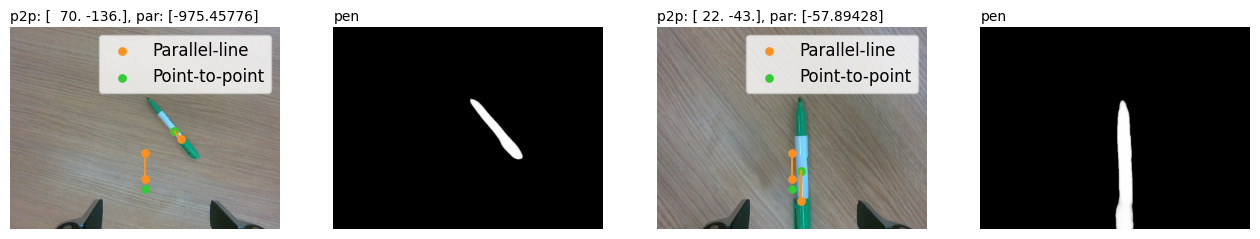

In [7]:
# Visualize what's in predictions
_, ax = plt.subplots(1, 4, figsize=(16, 4))
[a.axis('off') for a in ax.flatten()]

ax[0].imshow(frame_1)
ax[0].text(0, -15, "p2p: {}, par: {}".format(e_pp_1, e_par_1))
visualize_constraint_plt(kps_par_1, "par", ax[0])
visualize_constraint_plt(kps_pp_1, "p2p", ax[0])
ax[0].legend(fontsize="12")

ax[1].text(0, -15, prompt)
ax[1].imshow(preds[0], cmap="gray")

ax[2].text(0, -15, "p2p: {}, par: {}".format(e_pp_2, e_par_2))
ax[2].imshow(frame_2)
visualize_constraint_plt(kps_par_2, "par", ax[2])
visualize_constraint_plt(kps_pp_2, "p2p", ax[2])
ax[2].legend(fontsize="12")

ax[3].text(0, -15, prompt)
ax[3].imshow(preds[1], cmap="gray")

plt.show()